In [1]:
import pandas as pd
import numpy as np
import datetime
import re
import matplotlib.pyplot as plt
import time
import seaborn as sns
import pytz
from nltk.probability import FreqDist
from custom_scripts import *
%matplotlib inline

In [2]:
df1 = pd.read_csv('yearly_articles/apple2020.csv', index_col=0)
df2 = pd.read_csv('yearly_articles/apple2019.csv', index_col=0)
df3 = pd.read_csv('yearly_articles/apple2018.csv', index_col=0)
df4 = pd.read_csv('yearly_articles/apple2017.csv', index_col=0)
df5 = pd.read_csv('yearly_articles/apple2016.csv', index_col=0)
df6 = pd.read_csv('yearly_articles/apple2015.csv', index_col=0)
df = pd.concat([df1,df2, df3, df4, df5, df6])
df.dropna(subset=['fulltext'], inplace=True)
df.shape

(39512, 7)

# Clean newlines and special characters

In [3]:
%%time
df['cleaned_text'] = df['fulltext'].apply(clean_text)
df['cleaned_authors'] = df['author'].apply(clean_text)

CPU times: user 10.7 s, sys: 315 ms, total: 11 s
Wall time: 11.4 s


#### Changing the UTC time to EST.

In [4]:
#Change to Datetime
df["date"]= pd.to_datetime(df["date"])
df = df.set_index('date')
df.index = df.index.normalize()

In [5]:
%%time
#convert DateTime index to eastern time. 
eastern = pytz.timezone('US/Eastern')
df.index = df.index.tz_convert(eastern).tz_localize(None)
#put into year/month/day format
df.index = df.index.strftime('%Y-%m-%d')

CPU times: user 280 ms, sys: 8.35 ms, total: 289 ms
Wall time: 303 ms


# Using [tldextract](https://pypi.org/project/tldextract/) to extract company names from url's

In [6]:
%%time
df['news_outlet'] = df['source'].apply(get_outlet)
print('The dataset contains {} different articles from {} news outlets \n'.format(df.shape[0],df.news_outlet.nunique()))

The dataset contains 39512 different articles from 448 news outlets 

CPU times: user 431 ms, sys: 15.2 ms, total: 446 ms
Wall time: 468 ms


# Getting historical Stock Prices

In [ ]:
years_we_need = [2015, 2016, 2017, 2018, 2019, 2020]

full_date_list = []

for year in years_we_need:
    res = get_month_day_range(year)
    full_date_list += res

In [ ]:
historical_prices = get_past_prices(full_date_list, 'AAPL')

The loop below iterates through the historical prices and calculates the change in a stock price from one open to another. Adding a 0 if the stock decreased or there was not change, and adding a 1 if the stock increased. This is an initial tagging step, the threshold for targets can be adjusted later using the 'day_change' column.

In [ ]:
prices_index = historical_prices.index.strftime('%Y-%m-%d').to_list()

In [ ]:
df_res = pd.DataFrame(columns = ['day_change', 'increase', 'date'])
for i,stock_price in enumerate(prices_index):
    try:
        start = historical_prices.loc[prices_index[i]].open[0]
        stop = historical_prices.loc[prices_index[i+1]].open[0]
        direction = start - stop
        if direction < 0:
            increase = 0
        else:
            increase = 1
        df_res = df_res.append({'day_change': direction, 'increase':increase, 'date':stock_price}, ignore_index=True)
    except:
        continue

In [ ]:
df_res["date"]= pd.to_datetime(df_res["date"])
df_res = df_res.set_index('date')

In [ ]:
df_res.head(3)

In [ ]:
#shift all targets by one day because we want to predict one day in the future.
targets = df_res.shift(periods=1, fill_value=0)
targets.head()

In [ ]:
#merge the historical prices with the daily change we calculated and the targets. 
targs=pd.merge(targets,historical_prices, how='outer', left_index=True, right_index=True)

In [ ]:
targs.head(4)

In [7]:
#########
targs = pd.read_csv('targs.csv', index_col=0)

In [8]:
#Merge targets and main data on the date
df=pd.merge(df,targs, how='outer', left_index=True, right_index=True)

To account for weekends and holidays when the market is closed. Forward filling of the previous non-NA value is used. 

In [9]:
df.fillna(method='ffill', inplace = True)

#Drop the few late 2014 values where we have not price data. 
df.dropna(subset=['increase', 'open', 'high', 'low', 'close'], inplace = True)

# Predict Sentiment for each Article with VADER

In [12]:
%%time

#tag the sentiment for each article using VADER. This will take a few minutes.
df['sentiment'] = df['fulltext'].apply(sentiment_analyzer_scores)

CPU times: user 13min 39s, sys: 13.6 s, total: 13min 52s
Wall time: 14min 14s


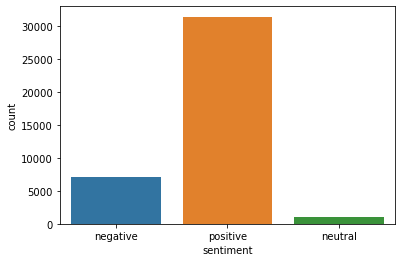

In [13]:
#visualize the sentiment distributions.
sns.countplot(df.sentiment);

After predicting sentiment of the article, dummy the sentiment column.

In [14]:
sentiment_dummies = pd.get_dummies(df['sentiment'], prefix='sent')
df = pd.concat([df, sentiment_dummies], axis=1)

In [15]:
df.head(2)

,update,source,author,fulltext,summary,title,cleaned_text,cleaned_authors,news_outlet,day_change,increase,open,high,low,close,volume,sentiment,sent_negative,sent_neutral,sent_positive
2015-01-02,2015-01-03 00:00:00,http://mg.co.za/article/2015-01-03-storage-war...,['Staff Reporter'],Apple on Friday faced a lawsuit accusing it of...,NaN,Storage war: Lawsuit accuses Apple of deceivin...,apple on friday faced a lawsuit accusing it of...,staff reporter,mg,-0.775,0.0,27.8475,27.86,26.8375,27.3325,53204600.0,negative,1,0,0
2015-01-02,2015-01-03 00:00:00,http://www.independent.ie/business/technology/...,[],Apple is being sued for lack of storage space ...,NaN,Apple sued over lack of storage space on devices,apple is being sued for lack of storage space ...,,independent,-0.775,0.0,27.8475,27.86,26.8375,27.3325,53204600.0,negative,1,0,0
2015-01-02,2015-01-03 03:24:55+00:00,http://www.inquisitr.com/1723450/iphone-6-plus...,['Patrick Frye'],An iPhone 6 Plus memory lawsuit is claiming th...,NaN,iPhone 6 Plus Memory Lawsuit Claims Apple Give...,an iphone 6 plus memory lawsuit is claiming th...,patrick frye,inquisitr,-0.775,0.0,27.8475,27.86,26.8375,27.3325,53204600.0,negative,1,0,0
2015-01-02,2015-01-03 03:24:55+00:00,http://www.abs-cbnnews.com/business/01/03/15/l...,['Agence France-Presse'],SAN FRANCISCO - Apple on Friday faced a lawsui...,NaN,Lawsuit accuses Apple of storage sleight of hand,san francisco apple on friday faced a lawsuit ...,agence france presse,abs-cbnnews,-0.775,0.0,27.8475,27.86,26.8375,27.3325,53204600.0,negative,1,0,0
2015-01-02,2015-01-03 00:00:00,http://www.euronews.com/2015/01/03/consumers-s...,[],Two Florida-based consumers have launched a la...,NaN,Consumers sue saying not-so-big Apple made fal...,two florida based consumers have launched a la...,,euronews,-0.775,0.0,27.8475,27.86,26.8375,27.3325,53204600.0,negative,1,0,0


# Tokenize

In [16]:
df['tokens'] = df['cleaned_text'].apply(toke)

# Lemmatize/Stop Word Removal

In [17]:
from nltk.corpus import stopwords

In [18]:
stop_words=list(set(stopwords.words("english")))

In [19]:
eda_stopwords = [
    'x', 'u', "'", 'e', 'a', 'i', 'n', 'u', 'd', 'c', 'p', 's', 'i',
    'o', 'r', 't', 'journalism', 'support', 'u', 'editor', 'fair', 'informed',
    'cookie', 'miamiaccording', 'article', 'expired', 'no', 'longer', 'want',
    'search', 'google', 'every', 'term', 'newswire', 'subscribe', 'button', 'close',
    'accept', 'goal', 'achieve', 'u', 'subscribed', 'many', 'continue', 'offer',
    'hard', 'provide', 'dear', 'reader', 'standard', 'always', 'strived', 'miamiinterested',
    'adopting', 'pet', 'gazing', 'lovable', 'pup', 'adoption', 'dog', 'animal', 'shelter',
    'ziprecruiter', 'miami', 'policy', 'clicking', 'explicit', 'consent',
    'please', 'see', 'even', 'better', 'relevant', 'goal', 'le', 'u,', 'philip', 'schiller',
    'believe', 'getty', 'josh', 'edelson', 'topical', 'issue', 'relevance',
    'seen', 'man', 'forward', 'dunkin', 'late', 'wife', 'bagelsee', 'rental', 'site', 'zumper',
    'quarantinefind', 'irvine', 'using', 'yelp', 'find', 'devon', 'horse', 'show',
    'urge', 'turn', 'ad', 'blocker', 'telegraph', 'barbecue', 'stop', 'crunched',
    'porch', 'ebay', 'amazon', 'curry', 'weeknightsset', 'easy', 'dinner', 'matter', 'partner',
    'find', 'detailed', 'description', 'apartment', 'got', 'news', 'mission', 'day', 'impersonal',
    'get', 'tip', 'top', 'mirror', 'newsletter', 'sign', 'thank', 'subscribing',
    'newsletter', 'invalid', 'full', 'swing', 'keen', 'get', 'hand', 'high', 'street',
    'john', 'lewis', 'curry', 'ton', 'currently', 'available', 'actual', 'check', 'back', 'also', 'honor',
    'writer', 'try', 'put', 'apartment', 'rent', 'via', 'go', 'rounded', 'dog', 'shelter', 'pup',
    'dozen', 'donut', 'south', 'targeted', 'practise', 'floridado', 'love', 'florida', 'doggy',
    'cancer', 'hide', 'caption', 'cooky', 'browser', 'sauce', 'pandemicthe',
    'something', 'penguina', 'eagle', 'email', 'notification', 'irvinein', 'hoodline',
    'recipe', 'perfect', 'meal', 'googlethe', 'v', 'doggy', 'delightful',
    'place', 'live', 'retire', 'takeout', 'youtubethe', 'barnes', 'museum',
    'cooking', 'nonstick', 'cookware', 'pretzelslearn', 'homemade', 'soft',
    'collectionsmany', 'franklin', 'u', 'gotten', 'tour', 'familiesthis',
    'best', 'spot', 'noticed', 'adblocking', 'help', 'fund', 'award', 'winning',
    'image', 'curry', 'ton', 'miamimiami', 'new', 'jersey', 'photographer',
    'authoritative', 'apartment', 'cheapest', 'downtown', 'bedroom', 'adventure',
    'aquarium', 'artwork', 'pretzel', 'click', 'play', 'tap', 'play',
    'aught', 'newsletter', 'pear', 'david', 'nield', 'gizmodo', 'pic', 'twitter',
    'com', 'thimbleweed', 'monument', 'pas', 'afp', 'u', 'prepear' 
]


stop_words.extend(eda_stopwords)

In [20]:
def remove_stopwords(text):
    return [word for word in text if word not in stop_words]

In [26]:
pre_process = [remove_stopwords, lemmatize_text, unlist]

for action in pre_process:
    df.tokens = df.tokens.apply(action)
    print('Completed: {}'.format(str(action)))

Completed: <function remove_stopwords at 0x7f9cf211a158>
Completed: <function lemmatize_text at 0x7f9cf5af6840>
Completed: <function unlist at 0x7f9cf5af6730>


In [29]:
df.drop_duplicates(subset=['tokens'], inplace=True)

# Aggregate the daily news articles

We will perform modeling on the aggregated article text per day. Our data is in a format that has each row as a new article, we want to aggregate all of the articles on a given day into a single row.

In [91]:
agged = df.copy()
agged.reset_index(inplace=True)
agged['date'] = pd.to_datetime(agged['index'])
agged.drop('index', axis=1, inplace=True)

In [92]:
#Add a column of 1's for when we aggregate all info into one column, we can add the 1's later to get the total articles per day. 
df['total_articles'] = 1

In [93]:
sentiment = agged.groupby('date')['sent_negative', 'sent_positive', 'total_articles'].agg(np.sum)
text = agged.groupby('date')['tokens'].agg(''.join)

In [94]:
agged = pd.merge(text, sentiment, how='inner', left_index=True, right_index=True)
#Merge targets
agged = pd.merge(agged, targs, how='inner', left_index=True, right_index=True)

In [95]:
agged.head(2)

,tokens,sent_negative,sent_positive,total_articles,day_change,increase,open,high,low,close,volume
2015-01-02,"apple, friday, faced, lawsuit, accusing, promi...",5,2,7,-0.7750,0.0,27.8475,27.8600,26.8375,27.3325,53204600
2015-01-05,"heard, much, hyped, apple, watch, would, arriv...",2,11,13,-0.4375,0.0,27.0725,27.1625,26.3525,26.5625,64285500
2015-01-06,"apple, watch, announced, company, showy, mediu...",1,13,14,0.1650,1.0,26.6350,26.8575,26.1575,26.5650,65797100
2015-01-07,"free, sends, biggest, headline, sport, showbiz...",2,15,17,0.5075,1.0,26.8000,27.0500,26.6750,26.9375,40105900


# Save the cleaned dataframe 

This dataframe will be used in the modeling process.

In [97]:
agged.to_pickle('maindf.pkl')

In [82]:
df.to_pickle('main_data/seperated_data.pkl')